# Question 5

# Part 1

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun April 5th

@author: Joshuah Touyz
@class: Anly-601
@title: HW3 Part 3
@lecture: L11 - Intro to deep learning
"""
# ---- Programming backprop from scratch -----
##########################
#   Importing libraries  #
##########################
import numpy as np
import pandas as pd
from matplotlib import pyplot as py
import time

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Generate some training    #
#      data from a GMM        #
###############################
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
    
    # Plot?
    if plot:
        py.scatter(xs[:1,:],xs[1:,:], c = cl)

    # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl
             
xs,y,cl = gen_gmm_data(plot = True)

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [2]:
#%%%%%%%%%%%%%%%%%%%%%%%
#    Hidden Units     #
#######################
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = lambda z: 1 / (1 + np.exp(-z))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer ReLU Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    H = ReLU(a1) * drop_out
    # H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    # dW = X.T.dot((Y_hat-Y).dot(V) * (H * (1 - H)))
    # db1 = (Y_hat-Y).dot(V) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
X, Y, cl = gen_gmm_data()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#      Building the model     #
###############################
def run_model(X, Y, cl,
              nodes_in_hidden_layer = 3,
              num_dim = 2,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 3, # <- number of classes in the problem
              iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        # Prediction and Error rate            
        errs_i = error_rate(Y_hat, cl) ; errors.append(errs_i)
        loss_i = cost(Y_hat, Y); losses.append(loss_i)
        if ((i % 25) == 0):    
            print(
            '''
            ---- Iteration {i} ----
            Error rate : {er}
            Loss: {loss}
            '''.format(i= i, er = errs_i, loss = loss_i))
    print(py.plot(range(0,iterations), losses))
    return {"errors":errs_i, "loss_i":loss_i, "parameters":parameters}

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Part A


            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5034085448333
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.39605917572297
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.17197232981295
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.61145170075919
            


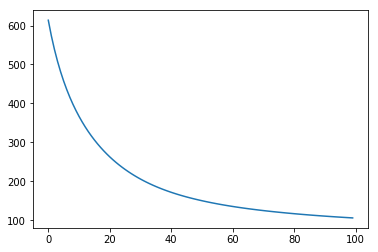

In [4]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Running Different Models  #
###############################
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.40354394647113
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.18172488031507
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.62280456538743
            


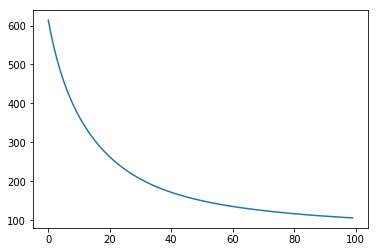

In [5]:
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.98295471923471
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100706
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.85085902810401
            


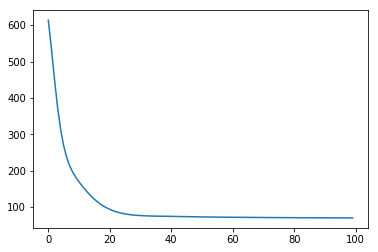

In [6]:
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.98295471923471
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100706
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.85085902810401
            


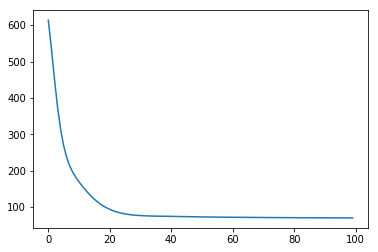

In [7]:
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 

It looks like the regularization schemes of sgd_w_momentum and sgd_w_reg_momentum_drop_out have the best performance (same loss at each iteration). These perform the same because there are only 3 nodes in the hidden layer so there isn't much risk of overfitting with excess nodes that need to be dropped. This is more likely to be the case once we have 5 nodes in the hidden layer.

## Part B


            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.817307396562
            

            ---- Iteration 25 ----
            Error rate : 0.19519519519519518
            Loss: 611.3706509095945
            

            ---- Iteration 50 ----
            Error rate : 0.06806806806806807
            Loss: 383.2276735915492
            

            ---- Iteration 75 ----
            Error rate : 0.042042042042042045
            Loss: 251.50549508774918
            


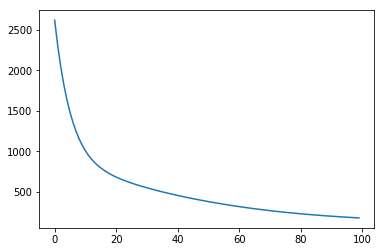

In [8]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 5,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.812898743622
            

            ---- Iteration 25 ----
            Error rate : 0.19519519519519518
            Loss: 611.3780321566293
            

            ---- Iteration 50 ----
            Error rate : 0.06806806806806807
            Loss: 383.24311052012064
            

            ---- Iteration 75 ----
            Error rate : 0.042042042042042045
            Loss: 251.5185754232598
            


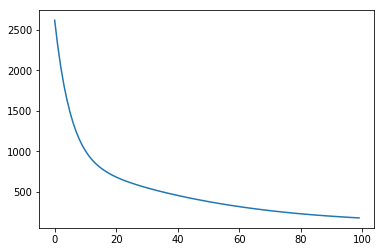

In [9]:
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 5,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.812898743622
            

            ---- Iteration 25 ----
            Error rate : 0.042042042042042045
            Loss: 177.33983329727536
            

            ---- Iteration 50 ----
            Error rate : 0.028028028028028028
            Loss: 92.94331996077938
            

            ---- Iteration 75 ----
            Error rate : 0.023023023023023025
            Loss: 83.57093363386093
            


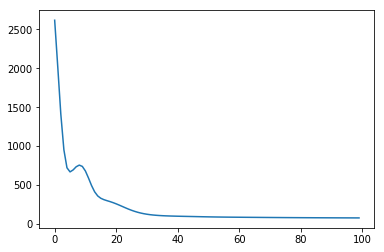

In [10]:
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              nodes_in_hidden_layer = 5,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.812898743622
            

            ---- Iteration 25 ----
            Error rate : 0.042042042042042045
            Loss: 177.33983329727536
            

            ---- Iteration 50 ----
            Error rate : 0.028028028028028028
            Loss: 92.94331996077938
            

            ---- Iteration 75 ----
            Error rate : 0.023023023023023025
            Loss: 83.57093363386093
            


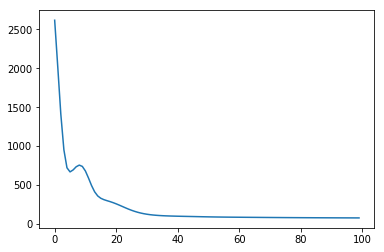

In [11]:
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      nodes_in_hidden_layer = 5,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 

Again, the  sgd_w_momentum and sgd_w_reg_momentum_drop_out have the best performance (same loss at each iteration). These perform the same because there are only 3 nodes in the hidden layer so there isn't much risk of overfitting with excess nodes that need to be dropped. This is more likely to be the case once we have 5 nodes in the hidden layer.

## Part C

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5034085448333
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.39605917572297
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.17197232981295
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.61145170075919
            
1.2350135080014297 seconds


C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


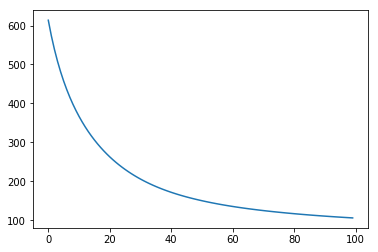

In [16]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#       Execution time.      #
###############################
start_time = time.clock()
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 3,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
print(time.clock() - start_time, "seconds")

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.40354394647113
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.18172488031507
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.62280456538743
            
1.2468404929986718 seconds


C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


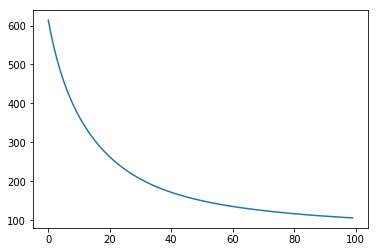

In [17]:
start_time = time.clock()
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 3,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
print(time.clock() - start_time, "seconds")

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.98295471923471
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100706
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.85085902810401
            
1.3105860630003008 seconds


C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


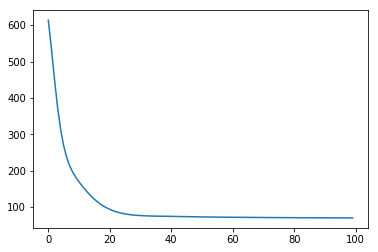

In [18]:
start_time = time.clock()
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              nodes_in_hidden_layer = 3,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
print(time.clock() - start_time, "seconds")

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.98295471923471
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100706
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.85085902810401
            
1.2909759909998684 seconds


C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


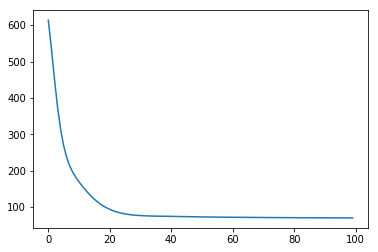

In [19]:
start_time = time.clock()
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      nodes_in_hidden_layer = 3,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
print(time.clock() - start_time, "seconds")

| Regularization Scheme       | Time           |
|-----------------------------|----------------|
| vanilla_sgd                 | 1.2350 seconds |
| sgd_w_reg                   | 1.2468 seconds |
| sgd_w_momentum              | 1.3106 seconds |
| sgd_w_reg_momentum_drop_out | 1.2910 seconds |

# Part 2

## Part A

In [ ]:
## %%%%%%%%%%%%%%%%%%%%%%%
#    Hidden Units     #
#######################
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = lambda z: 1 / (1 + np.exp(-z))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer ReLU Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    #H = ReLU(a1) * drop_out
    H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    #dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    #db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    dW = X.T.dot((Y_hat-Y).dot(V.T) * (H * (1 - H)))
    db1 = (Y_hat-Y).dot(V.T) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
X, Y, cl = gen_gmm_data()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#      Building the model     #
###############################
def run_model(X, Y, cl,
              nodes_in_hidden_layer = 3,
              num_dim = 2,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 3, # <- number of classes in the problem
              iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        # Prediction and Error rate            
        errs_i = error_rate(Y_hat, cl) ; errors.append(errs_i)
        loss_i = cost(Y_hat, Y); losses.append(loss_i)
        if ((i % 25) == 0):    
            print(
            '''
            ---- Iteration {i} ----
            Error rate : {er}
            Loss: {loss}
            '''.format(i= i, er = errs_i, loss = loss_i))
    print(py.plot(range(0,iterations), losses))
    return {"errors":errs_i, "loss_i":loss_i, "parameters":parameters}


            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601004579307
            

            ---- Iteration 25 ----
            Error rate : 0.17017017017017017
            Loss: 564.24839046222
            

            ---- Iteration 50 ----
            Error rate : 0.02902902902902903
            Loss: 471.05302961731525
            

            ---- Iteration 75 ----
            Error rate : 0.009009009009009009
            Loss: 394.6392869884486
            


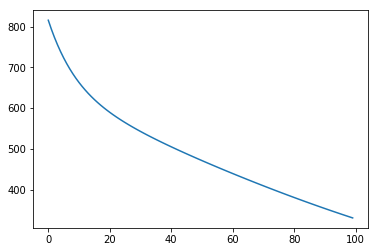

In [30]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Running Different Models  #
###############################
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601696175726
            

            ---- Iteration 25 ----
            Error rate : 0.17017017017017017
            Loss: 564.2584226286873
            

            ---- Iteration 50 ----
            Error rate : 0.02902902902902903
            Loss: 471.07374131205034
            

            ---- Iteration 75 ----
            Error rate : 0.009009009009009009
            Loss: 394.66892379160777
            


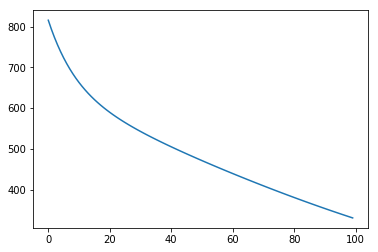

In [31]:
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601696175726
            

            ---- Iteration 25 ----
            Error rate : 0.002002002002002002
            Loss: 182.98683345381278
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 43.899542875758385
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 25.146346730882783
            


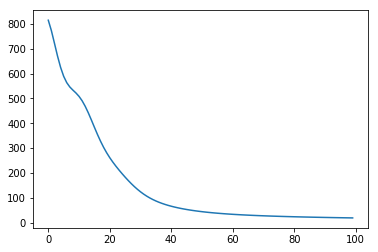

In [32]:
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601696175726
            

            ---- Iteration 25 ----
            Error rate : 0.002002002002002002
            Loss: 182.98683345381278
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 43.899542875758385
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 25.146346730882783
            


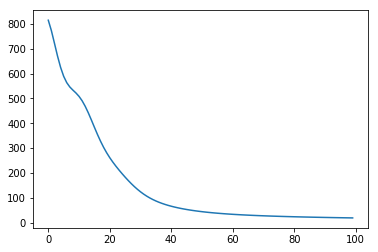

In [33]:
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True)

## Part B


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.586441627903
            

            ---- Iteration 25 ----
            Error rate : 0.3113113113113113
            Loss: 744.7528054802333
            

            ---- Iteration 50 ----
            Error rate : 0.004004004004004004
            Loss: 478.7947491808475
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 340.58028230286243
            


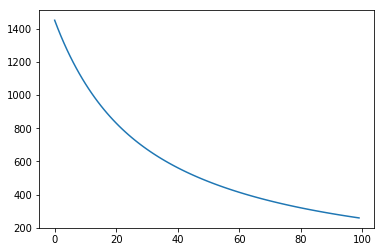

In [34]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 5,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5855664869066
            

            ---- Iteration 25 ----
            Error rate : 0.3113113113113113
            Loss: 744.7595116809231
            

            ---- Iteration 50 ----
            Error rate : 0.004004004004004004
            Loss: 478.8169756302765
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 340.6107055244833
            


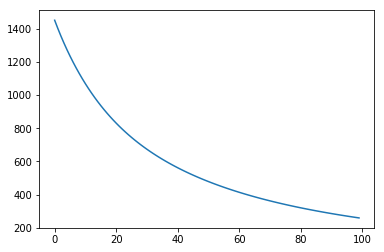

In [35]:
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 5,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5855664869066
            

            ---- Iteration 25 ----
            Error rate : 0.0
            Loss: 118.1251184766682
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 26.00402816914069
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 15.878006619973021
            


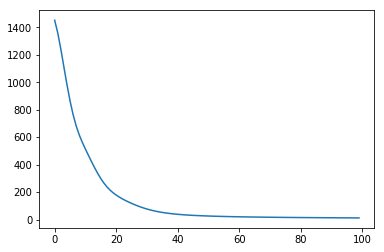

In [36]:
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              nodes_in_hidden_layer = 5,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5855664869066
            

            ---- Iteration 25 ----
            Error rate : 0.0
            Loss: 118.1251184766682
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 26.00402816914069
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 15.878006619973021
            


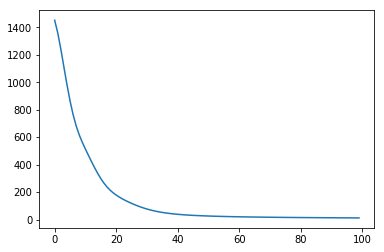

In [37]:
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      nodes_in_hidden_layer = 5,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 

## Part C

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys



            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601004579307
            

            ---- Iteration 25 ----
            Error rate : 0.17017017017017017
            Loss: 564.24839046222
            

            ---- Iteration 50 ----
            Error rate : 0.02902902902902903
            Loss: 471.05302961731525
            

            ---- Iteration 75 ----
            Error rate : 0.009009009009009009
            Loss: 394.6392869884486
            
0.07817786700070428 seconds


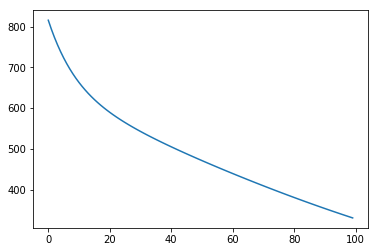

In [38]:
start_time = time.clock()
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 3,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
print(time.clock() - start_time, "seconds")

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys



            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601696175726
            

            ---- Iteration 25 ----
            Error rate : 0.17017017017017017
            Loss: 564.2584226286873
            

            ---- Iteration 50 ----
            Error rate : 0.02902902902902903
            Loss: 471.07374131205034
            

            ---- Iteration 75 ----
            Error rate : 0.009009009009009009
            Loss: 394.66892379160777
            
0.09821875899979204 seconds


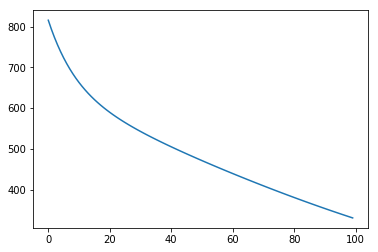

In [39]:
start_time = time.clock()
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              nodes_in_hidden_layer = 3,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
print(time.clock() - start_time, "seconds")

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys



            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601696175726
            

            ---- Iteration 25 ----
            Error rate : 0.002002002002002002
            Loss: 182.98683345381278
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 43.899542875758385
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 25.146346730882783
            
0.08508307700139994 seconds


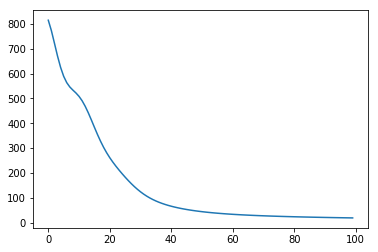

In [40]:
start_time = time.clock()
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              nodes_in_hidden_layer = 3,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
print(time.clock() - start_time, "seconds")

C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
C:\Users\singha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys



            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601696175726
            

            ---- Iteration 25 ----
            Error rate : 0.002002002002002002
            Loss: 182.98683345381278
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 43.899542875758385
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 25.146346730882783
            
0.08043807000103698 seconds


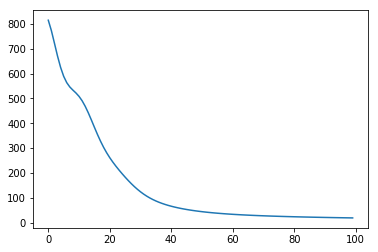

In [41]:
start_time = time.clock()
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      nodes_in_hidden_layer = 3,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
print(time.clock() - start_time, "seconds")

| Regularization Scheme       | ReLu Time      | Sigmoid Time   |
|-----------------------------|----------------|----------------|
| vanilla_sgd                 | 1.2350 seconds | 0.0782 seconds |
| sgd_w_reg                   | 1.2468 seconds | 0.0982 seconds |
| sgd_w_momentum              | 1.3106 seconds | 0.0851 seconds |
| sgd_w_reg_momentum_drop_out | 1.2910 seconds | 0.0804 seconds |